<font color='orange' size = 15px>Node Classification on arXiv-Paper</font>

**Title:** Node Classification on ArXiv-Paper Dataset with Multiple Methods

**Problem Definition:** The task at hand involves predicting the subject of each paper within the ArXiv-Paper dataset. Given the massive volume of papers, manual labeling becomes impractical. To address this, an automated approach is employed. The method takes a graph as input, where papers represent nodes and citations form edges. The goal is to predict the class of each test node.

**Dataset:**  The dataset used for this project is the [ArXiv-Paper dataset](https://snap.stanford.edu/ogb/data/misc/ogbn_arxiv/titleabs.tsv.gz){:target="_blank"} which comprises approximately 170,000 papers and 1,160,000 citations spanning 40 subject areas.

**Evaluation Metrics:**  Various metrics, including accuracy, loss, and others, will be employed to evaluate the performance of the classification methods.



### Install requirments

In [1]:
!pip install torch_geometric
!pip install ogb
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 969.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=4c147b9dda47ae4a620464a2b0d9c5f9d207256bcc2cffea03f8e280533b413e
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.4 MB/s eta 0:00:00


## Before diving into the project!

1.Graph Representation

2.Initialization

3.Message Passing

4.Aggregation Function

5.Neighborhood Information

6.Node Update

7.Convolutional Operation

8.Multiple Layers

9.Readout/Pooling

10.Output Layer

<img src="https://github.com/sarasadatnasr/Data_Science_Course_Final_Project/blob/23103319664f922e8409fc94df3149e65da7dcbe/Massagepassing.gif?raw=true" alt="Funny GIF" width="600" height="400">


### Import Requirements

In [2]:
import os
import pickle
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
from abc import ABC, abstractmethod
import torch_geometric.transforms as T
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
from torch_geometric.nn.conv import MixHopConv, SGConv, WLConvContinuous
from torch_geometric.nn.models import GAT, GCN, GIN, MLP, LabelPropagation
from torch_geometric.nn.conv import (MixHopConv, SGConv, SimpleConv,WLConvContinuous)
from torch_geometric.nn.models import MLP

<font color='Pink' size = 10px>Logger Class</font>

 this class is designed to log and summarize the results of multiple runs in a node classification task, providing statistics on training and validation accuracy for each run and aggregated statistics across all runs.

In [19]:
class Logger(object):
    def __init__(self, runs, info=None):
        self.info = info
        self.results = [[] for _ in range(runs)]

    def add_result(self, run, result):
        assert len(result) == 3
        assert run >= 0 and run < len(self.results)
        self.results[run].append(result)

    def print_statistics(self, run=None):
        if run is not None:
            result = 100 * torch.tensor(self.results[run])
            argmax = result[:, 1].argmax().item()
            print(f"Run {run + 1:02d}:")
            print(f"Highest Train: {result[:, 0].max():.2f}")
            print(f"Highest Valid: {result[:, 1].max():.2f}")
            print(f"  Final Train: {result[argmax, 0]:.2f}")
            print(f"   Final Test: {result[argmax, 2]:.2f}")
        else:
            result = 100 * torch.tensor(self.results)

            best_results = []
            for r in result:
                train1 = r[:, 0].max().item()
                valid = r[:, 1].max().item()
                train2 = r[r[:, 1].argmax(), 0].item()
                test = r[r[:, 1].argmax(), 2].item()
                best_results.append((train1, valid, train2, test))

            best_result = torch.tensor(best_results)

            print(f"All runs:")
            r = best_result[:, 0]
            print(f"Highest Train: {r.mean():.2f} ± {r.std():.2f}")
            r = best_result[:, 1]
            print(f"Highest Valid: {r.mean():.2f} ± {r.std():.2f}")
            r = best_result[:, 2]
            print(f"  Final Train: {r.mean():.2f} ± {r.std():.2f}")
            r = best_result[:, 3]
            print(f"   Final Test: {r.mean():.2f} ± {r.std():.2f}")


<font color='Pink' size = 10px>Models Class</font>


### Weisfeiler-Lehman (WL)

1.Node Labeling (Initialization)

2.Neighborhood Aggregation (Message Passing)

3.Node Label Update (Convolution)

4.Hashing/Sorting Labels

5.Unique Labels

6.Repaet

<img src="https://www.researchgate.net/publication/352370546/figure/fig1/AS:1166328576643072@1655085810624/a-Illustration-of-Weisfeiler-Lehman-WL-node-embedding-scheme-with-two-iterations.png" alt="Funny GIF" width="600" height="700">

In [4]:
class WLContinous(nn.Module):
    def __init__(self, data, num_layers: int, cached: bool = True) -> None:
        super().__init__()

        convs = [WLConvContinuous(cached=cached) for _ in range(num_layers)]
        self.convs = nn.ModuleList(convs)

        x = data.x
        for conv in self.convs:
            x = conv(x, data.edge_index)
        self.x = x

    def forward(self, **kwargs) -> torch.Tensor:
        return self.x

### Spectral Graph Convolution

1.Graph Laplacian

2.Spectral Decomposition

3.Graph Signal Transformation

4.Filtering in Spectral Domain

5.Inverse Transformation

6.Normalization

7.Learnable Parameters

8.Aggregation

9.Repeat Layers

<img src="https://miro.medium.com/v2/resize:fit:2000/1*WSvWVAsQsGtQQpIcrCPOOQ.png" alt="SG" width="600" height="400">

In [5]:
class SG(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, hops: int, cached: bool = True) -> None:
        super().__init__()

        self.conv = SGConv(in_channels=in_channels, out_channels=out_channels, K=hops, cached=cached)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        return self.conv(x, edge_index)

    def reset_parameters(self):
        self.conv.reset_parameters()

### Mix Hup GCN

1.Neighborhood Powers

2.Sparse Mixing

3.MixHop Convolutional Layer

4.Higher-Order Feature Learning

5.Reducing Computational Complexity

Paper: MixHop: Higher-Order Graph Convolutional Architectures via Sparsified Neighborhood Mixing

<img src="https://d3i71xaburhd42.cloudfront.net/4efb9a950f252138a30eeb942ed02663a3ea29d1/1-Figure1-1.png" alt="SG" width="600" height="360">

In [6]:
class MixHop(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, hops: int, num_layers: int, cached: bool = True) -> None:
        super().__init__()

        powers = [k for k in range(hops)]

        convs = [MixHopConv(in_channels=in_channels, out_channels=out_channels, powers=powers, cached=cached)]
        for _ in range(num_layers - 1):
            convs.append(MixHopConv(in_channels=len(powers) * out_channels, out_channels=out_channels, powers=powers, cached=cached))
        self.convs = nn.ModuleList(convs)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        for conv in self.convs:
            x = self.relu(conv(x, edge_index))

        return x

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()


### Mix Sum-Graph

1.Node Feature Iteration (Hops)

2.Concatenation of Node Features

3.Linear Transformation

In [7]:
class MixSG(nn.Module):
    def __init__(self, data, out_channels: int, hops: int, cached: bool = True) -> None:
        super().__init__()

        self.conv = SimpleConv(aggr="mean", combine_root=None, cached=cached)

        x_lst = [data.x]
        sum_x = torch.zeros_like(data.x)
        for _ in range(hops):
            new_x = self.conv.forward(x=x_lst[-1], edge_index=data.edge_index)

            new_x -= sum_x
            sum_x += new_x
            x_lst.append(new_x)

        self.x = torch.concat(x_lst, dim=1)
        self.w = nn.Linear(self.x.size(-1), out_channels)

    def forward(self, **kwargs) -> torch.Tensor:
        return self.w(self.x)

    def reset_parameters(self):
        self.w.reset_parameters()


<font color='Pink' size = 10px>Run Class</font>

This encapsulates common functionality for setting up a PyTorch-based machine learning experiment, handling device selection, dataset loading, and evaluation. Subclasses are required to implement the run method, which typically includes the training and inference logic specific to the model and task at hand.

In [8]:

class BaseRunner(ABC):
    def __init__(self, args):
        self.device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")

        if args.undirected == "true":
            self.dataset = PygNodePropPredDataset(name="ogbn-arxiv", transform=T.ToUndirected())
        elif args.undirected == "false":
            self.dataset = PygNodePropPredDataset(name="ogbn-arxiv")
        else:
            raise ValueError("Invalid undirected")

        self.data = self.dataset[0].to(self.device)
        self.split_idx = self.dataset.get_idx_split()
        self.train_idx = self.split_idx["train"].to(self.device)
        self.evaluator = Evaluator(name="ogbn-arxiv")

        self.conv_model: nn.Module

    def test(self, y_pred):
        train_acc = self.evaluator.eval(
            {
                "y_true": self.data.y[self.split_idx["train"]],
                "y_pred": y_pred[self.split_idx["train"]],
            }
        )["acc"]
        valid_acc = self.evaluator.eval(
            {
                "y_true": self.data.y[self.split_idx["valid"]],
                "y_pred": y_pred[self.split_idx["valid"]],
            }
        )["acc"]
        test_acc = self.evaluator.eval(
            {
                "y_true": self.data.y[self.split_idx["test"]],
                "y_pred": y_pred[self.split_idx["test"]],
            }
        )["acc"]

        return train_acc, valid_acc, test_acc

    @abstractmethod
    def run(self):
        pass


This class sets up a label propagation model (LabelPropagation) during initialization and provides methods for making predictions (predict) and running the complete experiment (run). The experiment involves obtaining predictions, evaluating the model's performance using the inherited test method, and logging the results using a logger (logger.add_result).

In [9]:
class LabelRunner(BaseRunner):
    def __init__(self, args):
        super().__init__(args)

        self.conv_model = LabelPropagation(num_layers=args.conv_num_layers, alpha=args.alpha).to(self.device)

    def predict(self):
        out = self.conv_model(y=self.data.y, edge_index=self.data.edge_index, mask=self.train_idx)
        y_pred = out.argmax(dim=-1, keepdim=True)

        return y_pred

    def run(self):
        y_pred = self.predict()
        result = self.test(y_pred)
        logger.add_result(run, result)


In [10]:
class WLRunner(BaseRunner):
    def __init__(self, args) -> None:
        super().__init__(args)

        self.epochs = args.epochs
        self.lr = args.lr
        self.conv_model = WLContinous(data=self.data, num_layers=args.conv_num_layers, cached=True).to(self.device)

        clf_channels_list = [self.data.x.size(-1)]
        for _ in range(args.clf_num_layers - 2):
            clf_channels_list.append(clf_channels_list[-1] // 2)
        clf_channels_list.append(self.dataset.num_classes)
        self.clf = MLP(channel_list=clf_channels_list, cached=True).to(self.device)

    def learn(self, criterion, optimizer):
        self.clf.train()

        hidden = self.conv_model(x=self.data.x, edge_index=self.data.edge_index)[self.train_idx]
        out = self.clf(hidden)
        loss = criterion(out, self.data.y.squeeze(1)[self.train_idx])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    def predict(self):
        self.clf.eval()

        hidden = self.conv_model(x=self.data.x, edge_index=self.data.edge_index)
        out = self.clf(hidden)
        y_pred = out.argmax(dim=-1, keepdim=True)

        return y_pred

    def run(self):
        self.clf.reset_parameters()

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(self.clf.parameters(), self.lr)

        for epoch in range(self.epochs):
            loss = self.learn(criterion=criterion, optimizer=optimizer)
            y_pred = self.predict()
            result = self.test(y_pred)

            logger.add_result(run, result)

            train_acc, valid_acc, test_acc = result
            print(
                f"Epoch: {epoch:02d}, "
                f"Loss: {loss:.4f}, "
                f"Train: {100 * train_acc:.2f}%, "
                f"Valid: {100 * valid_acc:.2f}% "
                f"Test: {100 * test_acc:.2f}%"
            )


In [11]:
class GNNRunner(BaseRunner):
    def __init__(self, args) -> None:
        super().__init__(args)

        self.epochs = args.epochs
        self.lr = args.lr

        if args.conv == "gcn":
            self.conv_model = GCN(
                in_channels=self.data.num_features,
                hidden_channels=args.conv_hidden_channels,
                num_layers=args.conv_num_layers,
                cached=True,
            )
        elif args.conv == "gat":
            self.conv_model = GAT(
                in_channels=self.data.num_features,
                hidden_channels=args.conv_hidden_channels,
                num_layers=args.conv_num_layers,
                cached=True,
            )
        elif args.conv == "gin":
            self.conv_model = GIN(
                in_channels=self.data.num_features,
                hidden_channels=args.conv_hidden_channels,
                num_layers=args.conv_num_layers,
                cached=True,
            )
        elif args.conv == "sgc":
            self.conv_model = SG(
                in_channels=self.data.num_features,
                out_channels=args.conv_hidden_channels,
                hops=args.conv_hops,
                cached=True,
            )
        elif args.conv == "mixhop":
            self.conv_model = MixHop(
                in_channels=self.data.num_features,
                out_channels=args.conv_hidden_channels // args.conv_hops,
                hops=args.conv_hops,
                num_layers=args.conv_num_layers,
                cached=True,
            )
        elif args.conv == "mixsgc":
            self.conv_model = MixSG(
                data=self.data,
                out_channels=args.conv_hidden_channels,
                hops=args.conv_hops,
                cached=True,
            )
        else:
            raise ValueError("Invalid convolution")

        self.conv_model = self.conv_model.to(self.device)

        clf_channels_list = [args.conv_hidden_channels]
        for _ in range(args.clf_num_layers - 2):
            clf_channels_list.append(clf_channels_list[-1] // 2)
        clf_channels_list.append(self.dataset.num_classes)
        self.clf = MLP(channel_list=clf_channels_list, cached=True).to(self.device)

    def learn(self, criterion, optimizer):
        self.conv_model.train()
        self.clf.train()

        hidden = self.conv_model(x=self.data.x, edge_index=self.data.edge_index)[self.train_idx]
        out = self.clf(hidden)
        loss = criterion(out, self.data.y.squeeze(1)[self.train_idx])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    def predict(self):
        with torch.no_grad():
            self.conv_model.eval()

            hidden = self.conv_model(x=self.data.x, edge_index=self.data.edge_index)
            out = self.clf(hidden)
            y_pred = out.argmax(dim=-1, keepdim=True)

            return y_pred

    def run(self):
        self.clf.reset_parameters()
        self.conv_model.reset_parameters()

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(list(self.conv_model.parameters()) + list(self.clf.parameters()), self.lr)

        for epoch in range(self.epochs):
            loss = self.learn(criterion=criterion, optimizer=optimizer)
            y_pred = self.predict()
            result = self.test(y_pred)

            logger.add_result(run, result)

            train_acc, valid_acc, test_acc = result
            print(
                f"Epoch: {epoch:02d}, "
                f"Loss: {loss:.4f}, "
                f"Train: {100 * train_acc:.2f}%, "
                f"Valid: {100 * valid_acc:.2f}% "
                f"Test: {100 * test_acc:.2f}%"
            )

In [12]:
if __name__ == "__main__":
    # Parse args and initialize logger
    parser = argparse.ArgumentParser(description="OGBN-Arxiv (GNN)")
    parser.add_argument("--undirected", type=str, choices=["true", "false"], default="true")
    parser.add_argument(
        "--conv",
        type=str,
        choices=[
            "lp",
            "wl",
            "sgc",
            "mixsgc",
            "gcn",
            "gin",
            "mixhop",
        ],
        default="mixsgc",
    )
    parser.add_argument("--device", type=int, default=0)
    parser.add_argument("--conv_num_layers", type=int, default=3)
    parser.add_argument("--conv_hidden_channels", type=int, default=63)  # For mixhop, hidden channels needs to be divisible by hops
    parser.add_argument("--conv_hops", type=int, default=3)
    parser.add_argument("--clf_num_layers", type=int, default=1)
    parser.add_argument("--lr", type=float, default=0.01)
    parser.add_argument("--epochs", type=int, default=200)
    parser.add_argument("--alpha", type=float, default=0.9)
    parser.add_argument("--runs", type=int, default=5)
    args = parser.parse_args([])
    print(args)
    logger = Logger(args.runs, vars(args))

    # Make sure that hops divides hidden channels
    args.conv_hidden_channels = (args.conv_hidden_channels // args.conv_hops) * args.conv_hops

    # Initialize runner
    if args.conv in ["lp"]:
        runner = LabelRunner(args=args)
    elif args.conv in ["wl"]:
        runner = WLRunner(args=args)
    else:
        runner = GNNRunner(args=args)
    print(runner.conv_model)

    # Begin training
    for run in range(args.runs):
        runner.run()
        logger.print_statistics(run)
    logger.print_statistics()

    os.makedirs("logs", exist_ok=True)

    with open(f'logs/{args.conv}.pkl', 'wb') as f:
        pickle.dump(logger, f)

Namespace(undirected='true', conv='mixsgc', device=0, conv_num_layers=3, conv_hidden_channels=63, conv_hops=3, clf_num_layers=1, lr=0.01, epochs=200, alpha=0.9, runs=5)


Downloaded 0.08 GB: 100%|██████████| 81/81 [00:05<00:00, 14.04it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 2111.94it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 194.70it/s]

Saving...



Done!


MixSG(
  (conv): SimpleConv()
  (w): Linear(in_features=512, out_features=63, bias=True)
)
Epoch: 00, Loss: 3.7084, Train: 18.63%, Valid: 9.16% Test: 7.06%
Epoch: 01, Loss: 3.2609, Train: 19.66%, Valid: 11.16% Test: 8.69%
Epoch: 02, Loss: 3.0909, Train: 27.88%, Valid: 30.63% Test: 34.94%
Epoch: 03, Loss: 2.9735, Train: 32.93%, Valid: 37.12% Test: 40.06%
Epoch: 04, Loss: 2.8745, Train: 29.64%, Valid: 30.56% Test: 27.51%
Epoch: 05, Loss: 2.7805, Train: 28.07%, Valid: 30.02% Test: 27.00%
Epoch: 06, Loss: 2.7181, Train: 29.12%, Valid: 30.75% Test: 27.58%
Epoch: 07, Loss: 2.6474, Train: 30.82%, Valid: 31.79% Test: 28.83%
Epoch: 08, Loss: 2.5530, Train: 34.80%, Valid: 37.68% Test: 37.86%
Epoch: 09, Loss: 2.4696, Train: 36.63%, Valid: 42.39% Test: 45.15%
Epoch: 10, Loss: 2.4034, Train: 39.23%, Valid: 45.36% Test: 47.90%
Epoch: 11, Loss: 2.3283, Train: 41.03%, Valid: 45.25% Test: 45.87%
Epoch: 12, Loss: 2.2511, Train: 41.13%, Valid: 42.43% Test: 40.95%
Epoch: 13, Loss: 2.1842, Train: 42.02%, V

<ipython-input-4-632bb35aee6b>:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_latex.to_latex(escape=False)


,highest_train,highest_valid,final_train,final_test
mixhop,64.8 +/- 0.71,65.48 +/- 0.75,64.76 +/- 0.7,64.56 +/- 0.67
sgc,68.92 +/- 0.06,68.58 +/- 0.08,68.92 +/- 0.06,67.55 +/- 0.05
lp,86.78 +/- 0.0,70.16 +/- 0.0,86.78 +/- 0.0,68.14 +/- 0.0
mixsgc,69.85 +/- 0.05,68.22 +/- 0.07,69.76 +/- 0.11,67.4 +/- 0.29
gin,28.54 +/- 4.45,31.35 +/- 4.47,27.8 +/- 5.12,29.98 +/- 3.67
gcn,67.86 +/- 0.23,67.93 +/- 0.27,67.78 +/- 0.15,67.11 +/- 0.35
wl,63.37 +/- 0.04,63.61 +/- 0.15,63.37 +/- 0.04,62.62 +/- 0.08


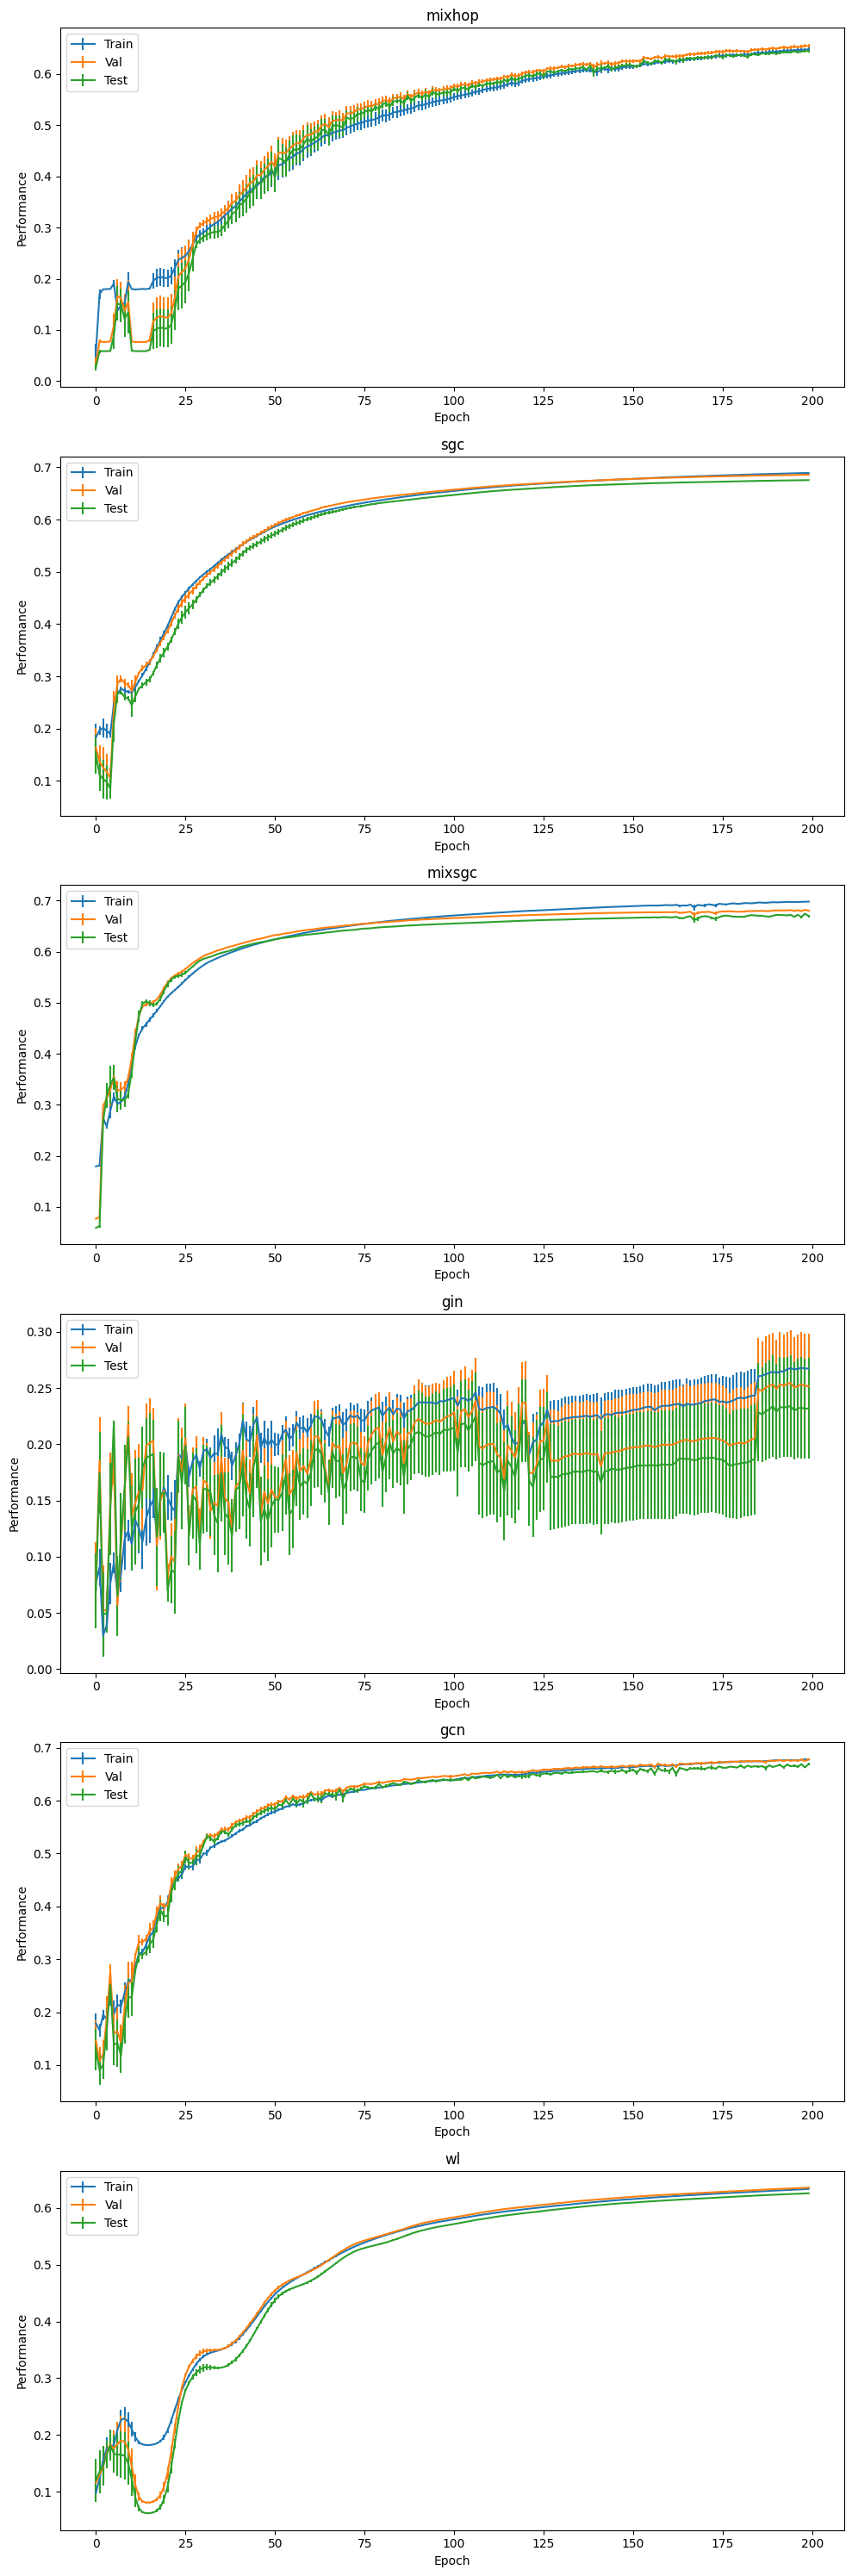

In [4]:
# Read logs
directory = 'logs'
files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
results = {}
for file in files:
    with open(os.path.join(directory, file), 'rb') as f:
        results[file[:-4]] = pickle.load(f).results

# Create table
data = {key: {"highest_train": (0,0), "highest_valid": (0,0), "final_train": (0,0), "final_test": (0,0)} for key in results.keys()}
for key, result in results.items():
    result = 100 * np.array(result)

    best_results = []
    for run in result:
        train1 = run[:, 0].max().item()
        valid = run[:, 1].max().item()
        train2 = run[run[:, 1].argmax(), 0].item()
        test = run[run[:, 1].argmax(), 2].item()
        best_results.append((train1, valid, train2, test))

    best_result = np.array(best_results)

    run = best_result[:, 0]
    data[key]["highest_train"] = (run.mean(), run.std())
    run = best_result[:, 1]
    data[key]["highest_valid"] = (run.mean(), run.std())
    run = best_result[:, 2]
    data[key]["final_train"] = (run.mean(), run.std())
    run = best_result[:, 3]
    data[key]["final_test"] = (run.mean(), run.std())

df = pd.DataFrame(data).T
df_mean = df.applymap(lambda x: round(x[0], 2)).astype(str)
df_std = df.applymap(lambda x: round(x[1], 2)).astype(str)

df_latex = df_mean + ' $\\pm$ ' + df_std
latex_table = df_latex.to_latex(escape=False)
with open("table.tex", "w") as f:
    f.write(latex_table)

display(df_mean + ' +/- ' + df_std)

# Draw plots
results.pop("lp")
fig, axs = plt.subplots(len(results), figsize=(10, 30))

for ax, (algorithm, runs) in zip(axs, results.items()):
    transposed_runs = [list(map(list, zip(*run))) for run in runs]

    means = np.mean(transposed_runs, axis=0)
    std_errors = np.std(transposed_runs, axis=0) / np.sqrt(len(transposed_runs))

    for i, (mean, std_error) in enumerate(zip(means, std_errors)):
        ax.errorbar(range(len(mean)), mean, yerr=std_error, label=['Train', 'Val', 'Test'][i])

    ax.set_title(algorithm)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Performance')
    ax.legend()

plt.tight_layout()
plt.show()
